# Ephemeris object imaging: continuum (mosaic gridder) with startmodel
This nootebook demonstlates continuum imaging of the ephemeris objects. 
In the following steps first we use the attached ephemeris table(s). 
It is assumed that the attached ephemeris table is the one used by the correlator.
The mosaic gridder is used so that the beam is tracked correctly.

## 1) Use 'TRACKFIELD' in phasecenter parameter 


This nootebook demonstlates continuum imaging of the ephemeris objects. 
In the following steps first we use the attached ephemeris table(s). 

It is assumed that the attached ephemeris table is the one used by the correlator.

In [16]:
# extra packages needed
#import os
#os.system('pip install astropy')
# for plotting images
#os.system('pop install aplpy')

In [17]:
from casatasks import getephemtable, tclean, exportfits, listobs, clearstat
from casatools import measures, quanta, table, image, msmetadata
import os
import aplpy
from astropy.io import fits
from matplotlib import pyplot
import pylab as pl
import shutil
me = measures()
qa = quanta()
tb = table()
ia = image()
msmd = msmetadata()

Define some helper funcitons

delete_tcleanimages: delete previous images from tclean run

get_attachedEphemtablepath: returns full eph table path for the corresponding field id

In [18]:
def delete_tcleanimages(imagename):
    ''' clean up images from a previous run '''
    imtypes = ['residual', 'image', 'psf', 'pb', 'model', 'sumwt','mask']
    for type in imtypes:
        if os.path.exists(f'{imagename}.{type}'):
            os.system(f'rm -rf {imagename}.{type}')

In [19]:
def get_attachedEphemtablepath(msfile, fieldid):
    ''' returns full path of attached eph table for a specified field ID'''
    import glob
    from casatools import table
    _tb = table()
    _tb.open(msfile+'/FIELD')
    ephemid = _tb.getcell('EPHEMERIS_ID',fieldid)
    _tb.close()
    tabname = glob.glob(f'{msfile}/FIELD/EPHEM{ephemid}*/')
    return os.path.abspath(tabname[0])

In order to track the ephemeris source during the observations, the proper ephemeris data is used. 
Ususally such ephemeris data table(s) are attached to the Measurement Set automatically during importadm when they are available. There may be multiple tables per MS but only single table is linked each field. The tables are used to calculate phases for gridding visibility. The ephemeis table is also used to stop the moving source. Setting phasecenter='TRACKFIELD' allows to use the same table for phase calculation  and stopping of the moving source.

In [20]:
# Use the ALMA Venus data in casatestdata
datapath='/home/casa/data/casatestdata/measurementset/alma/'
# Use local data directory
#datapath='/Volumes/ssd1/casatestdata/measurementset/alma/'
#datapath='/Users/ttsutsum/SWDevel/ephemdemo/notebooks/'

In [21]:
# Copy the data to the local directory (not neccessary)
msfile='venus_ephem_test.ms'
if os.path.exists(msfile):
    shutil.rmtree(msfile)
os.system(f'cp -r {datapath}{msfile} {msfile}')

0

In [48]:
imgname='mosaic-mfs-trackfield-venus'
img2name = 'mosaic-mfs-trackfield-venus-startmodel'

In [56]:
delete_tcleanimages(imgname)
delete_tcleanimages(img2name)

Run mosaic with usepointing = True to correctly shift the beam 

In [57]:
ret=tclean(vis=msfile, field='Venus', imagename=imgname, imsize=[288, 288], cell=['0.14arcsec'], 
           phasecenter='TRACKFIELD', specmode='mfs', gridder='mosaic', usepointing=True, niter=100, cycleniter=50)
ret['iterdone']

2024-04-18 23:42:32	WARN	tclean::::casa	Warning! Non-zero values at the edge of the .pb image can cause unexpected aliasing effects! (found value 0.722619354724884 at index [284, 144, 0, 0])


100

In [66]:
print(ret['summaryminor'][0][0][0]['modelFlux'])

[-1.648373007774353, -0.8706982135772705]


In [59]:
ret2=tclean(vis=msfile, field='Venus', imagename=img2name, imsize=[288, 288], cell=['0.14arcsec'], 
           phasecenter='TRACKFIELD', specmode='mfs', gridder='mosaic', usepointing=True, niter=100, 
           cycleniter=50, startmodel='mosaic-mfs-trackfield-venus.model',fullsummary=True)
ret2['iterdone']

2024-04-18 23:42:52	WARN	tclean::::casa	Warning! Non-zero values at the edge of the .pb image can cause unexpected aliasing effects! (found value 0.722619354724884 at index [284, 144, 0, 0])


100

In [65]:
print(ret2['summaryminor'][0][0][0]['startModelFlux'])

[-0.8706983327865601, -0.5580592751502991]


Convert a CASA image to FITS image for displaying the image via aplpy

In [67]:
# Define functions to use in displaying the image
def displayImage(imgname, markers={}, title=''):
    ''' convert casa image to fits and display the fits image'''
    # export to a FITS image (overwrite if the output exists)
    from casatools import quanta
    _qa = quanta()
    fitsimagename = imgname+'fits'
    exportfits(imagename=imgname, fitsimage=fitsimagename, overwrite=True)
    fits.setval(fitsimagename, 'TIMESYS', value='utc')
    fig = pl.figure(figsize=(15,15))
    img = aplpy.FITSFigure(fitsimagename, subplot=[0.1,0.1,0.5,0.5])
    img.show_colorscale()
    if markers!={}:
       for ky, pos in markers.items(): 
          if 'ra' in pos and 'dec' in pos:
             print(f'ky={ky}')
             if 'ext' in ky: 
                 color = 'red'
             else:
                 color = 'yellow'
             img.show_markers(pos['ra'], pos['dec'], edgecolor=color, marker='o',s=10, alpha=0.5)
             marker_ra = _qa.time(_qa.quantity(pos['ra'],'deg'),prec=9)[0]
             marker_dec = _qa.angle(_qa.quantity(pos['dec'],'deg'),prec=9)[0]
             print(f'{ky} at: {marker_ra}, {marker_dec}')
    pl.title(title)
    fig.canvas.draw()
    print('image center:',printImageCenter(imgname))

#def displayImage(imgname, markers={}, title=''):
#    ''' convert casa image to fits and display the fits image'''
#    # export to a FITS image (overwrite if the output exists)
#    fitsimagename = imgname+'fits'
#    exportfits(imagename=imgname, fitsimage=fitsimagename, overwrite=True)
#    fits.setval(fitsimagename, 'TIMESYS', value='utc')
#    fig = pl.figure(figsize=(15,15))
#    img = aplpy.FITSFigure(fitsimagename, subplot=[0.1,0.1,0.5,0.5])
#    img.show_colorscale()
#    if markers!={}:
#       img.show_markers(markers['ra'], markers['dec'], edgecolor='red', marker='o',s=10, alpha=0.5)
#       marker_ra = qa.time(qa.quantity(markers['ra'],'deg'),prec=9)[0]
#       marker_dec = qa.angle(qa.quantity(markers['dec'],'deg'),prec=9)[0]
#       print(f'marker at: {marker_ra}, {marker_dec}')
#    pl.title(title)
#    fig.canvas.draw()
#    print('image center:',printImageCenter(imgname))

def printImageCenter(imgname):
    from casatools import image, quanta
    _ia = image()
    _qa = quanta()
    _ia.open(imgname)
    shape = _ia.shape()
    csys = _ia.coordsys()
    center = csys.toworld([shape[0]/2.,shape[1]/2.])
    _ia.done()
    return _qa.time(_qa.quantity(center['numeric'][0], 'rad'),prec=9)[0], _qa.angle(_qa.quantity(center['numeric'][1],'rad'),prec=9)[0]

# Returns direction of the ephemeris object at a given time (parallax collected)
def ephem_dir(ephemtab, refep, observatory):
    from casatools import measures
    _me = measures()
    _me.framecomet(ephemtab)
    _me.doframe(_me.observatory(observatory))
    _me.doframe(_me.epoch('utc',refep))
    return _me.measure(_me.measure(_me.direction('COMET'), 'AZELGEO'),'ICRS')
    

Get the direction of Venus at the first timestamp of the select data from the ephemeris table

In [68]:
# Find the path of the attached ephem. table for fieldid=0
ephemtab = get_attachedEphemtablepath(msfile,0)
print(ephemtab)

/export/home/murasame2/casadev/ephemimaging/demo/notebooks/venus_ephem_test.ms/FIELD/EPHEM0_Venus_58491.4.tab


In [69]:
from casatasks import imhead
iminfo=imhead(img2name+'.image', mode='list')
iminfo['date-obs']

'2019/01/08/11:21:50.208000'

In [70]:

ineph_dir = ephem_dir(ephemtab, iminfo['date-obs'],'ALMA')
print(ineph_dir)
ineph_rad = qa.convert(ineph_dir['m0'],'deg')
ineph_decd = qa.convert(ineph_dir['m1'],'deg')
inephmarker = {'ineph':{'ra':ineph_rad['value'], 'dec':ineph_decd['value']}}

{'m0': {'unit': 'rad', 'value': -2.1053946095161686}, 'm1': {'unit': 'rad', 'value': -0.2960760011918846}, 'refer': 'ICRS', 'type': 'direction'}


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.621e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.556e+00 [aplpy.core]
ky=ineph


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


ineph at: 15:57:28.746, -016.57.50.059
image center: ('15:57:28.746', '-016.57.50.059')


<Figure size 1500x1500 with 0 Axes>

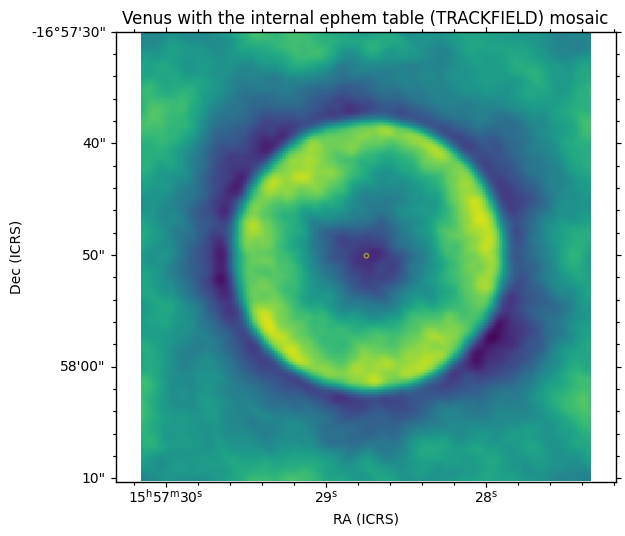

In [71]:
displayImage(img2name+'.image', markers=inephmarker, title='Venus with the internal ephem table (TRACKFIELD) mosaic')

Note: the marker in yellow is set to the direction based on the internal ephemeris table at the first time of the selected data and its coordintes agree with the coordinates of the center of the image.

In [72]:
print("internal ephem dir = ",qa.time(ineph_dir['m0'],prec=9),qa.angle(ineph_dir['m1'],prec=9))
printImageCenter(imgname+'.image')

internal ephem dir =  ['15:57:28.746'] ['-016.57.50.059']


('15:57:28.746', '-016.57.50.059')